### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.4 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/"

### Classical CNN Model Construction and General Methods

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
class TwoClassImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)

        self.class_to_idx = {
            'anormal': 0,
            'bsuspectglaucoma': 1,
            'cglaucoma': 1
        }

    def __getitem__(self, index):
        # Get original image and label
        path, original_target = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            sample = self.transform(sample)

        target_class_name = self.classes[original_target]
        target = self.class_to_idx[target_class_name]

        return sample, target

In [ ]:
def load_data(batch_size, dataset, PAPILA_dual_class=False):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

    if PAPILA_dual_class:
      train_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
      val_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'val'), transform=valid_test_transform)
      test_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'test'), transform=valid_test_transform)

    else:
      train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
      val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
      test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader


  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

  return train_loader, valid_loader, test_loader

### Hybrid Quantum-classical Neural Network Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_auc = float('-inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_auroc > best_val_auc:
            best_val_auc = val_auroc
            best_model_weights = model.state_dict()

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))
  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
  plt.style.use("seaborn")
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

  ax1.plot(quantum_loss, label="With quantum layer")
  ax1.plot(normal_loss, label="Without quantum layer")
  ax1.set_ylabel("Loss")
  ax1.set_ylim([0, 1])
  ax1.set_xlabel("Epoch")
  ax1.legend()

  ax2.plot(quantum_acc, label="With quantum layer")
  ax2.plot(normal_acc, label="Without quantum layer")
  ax2.set_ylabel("Accuracy")
  ax2.set_ylim([0, 100])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  ax2.plot(quantum_auc, label="With quantum layer")
  ax2.plot(normal_auc, label="Without quantum layer")
  ax2.set_ylabel("ROCAUC")
  ax2.set_ylim([0, 1])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch

def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Hybrid model predictions
            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)  # Probability for each class

            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)  # Probability for each class

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)

    # Calculate accuracy
    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)

    # Calculate F1 Score
    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')

    print(f'Hybrid Model Accuracy: {accuracy_hybrid * 100:.2f}%')
    print(f'Normal Model Accuracy: {accuracy_normal * 100:.2f}%')
    print(f'Hybrid Model F1 Score: {f1_hybrid:.4f}')
    print(f'Normal Model F1 Score: {f1_normal:.4f}')

    if num_classes == 2:  # Binary Classification
        # Extract the probabilities of the positive class (class 1)
        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        # Calculate AUC
        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUC: {auc_hybrid:.4f}')
        print(f'Normal Model AUC: {auc_normal:.4f}')

        # Plot ROC curves
        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUC = {auc_hybrid:.4f}')
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
        plt.title('ROC Curve - Hybrid and Normal Models')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Calculate and print AUPR
        precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels, all_probs_hybrid_class1)
        precision_normal, recall_normal, _ = precision_recall_curve(all_labels, all_probs_normal_class1)

        aupr_hybrid = auc(recall_hybrid, precision_hybrid)
        aupr_normal = auc(recall_normal, precision_normal)

        print(f'Hybrid Model AUPR: {aupr_hybrid:.4f}')
        print(f'Normal Model AUPR: {aupr_normal:.4f}')

        # Plot Precision-Recall curves
        plt.figure(figsize=(10, 6))
        plt.plot(recall_hybrid, precision_hybrid, label=f'Hybrid Model AUPR = {aupr_hybrid:.4f}')
        plt.plot(recall_normal, precision_normal, label=f'Normal Model AUPR = {aupr_normal:.4f}')
        plt.title('Precision-Recall Curve - Hybrid and Normal Models')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
        plt.show()

    else:  # Multi-class Classification
        # For multi-class, handle per class ROC and PR curves
        for i in range(num_classes):
            # Calculate AUC for each class
            fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels == i, all_probs_hybrid[:, i])
            fpr_normal, tpr_normal, _ = roc_curve(all_labels == i, all_probs_normal[:, i])

            auc_hybrid = roc_auc_score(all_labels == i, all_probs_hybrid[:, i])
            auc_normal = roc_auc_score(all_labels == i, all_probs_normal[:, i])

            plt.figure(figsize=(10, 6))
            plt.plot(fpr_hybrid, tpr_hybrid, label=f'Class {i} Hybrid Model AUC = {auc_hybrid:.4f}')
            plt.plot(fpr_normal, tpr_normal, label=f'Class {i} Normal Model AUC = {auc_normal:.4f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve - Class {i}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()

            # Precision-Recall Curve
            precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels == i, all_probs_hybrid[:, i])
            precision_normal, recall_normal, _ = precision_recall_curve(all_labels == i, all_probs_normal[:, i])

            aupr_hybrid = auc(recall_hybrid, precision_hybrid)
            aupr_normal = auc(recall_normal, precision_normal)

            plt.figure(figsize=(10, 6))
            plt.plot(recall_hybrid, precision_hybrid, label=f'Class {i} Hybrid Model AUPR = {aupr_hybrid:.4f}')
            plt.plot(recall_normal, precision_normal, label=f'Class {i} Normal Model AUPR = {aupr_normal:.4f}')
            plt.title(f'Precision-Recall Curve - Class {i}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc='lower left')
            plt.show()


# Experiments: Training Model on G1020 - Testing on G1020

In [ ]:
n_epochs = 100
num_classes = 2
q_depth = 4
batch_size = 32
dataset = "G1020"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Seed Experiment 1

In [ ]:
seed = 0
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6147, Training Accuracy: 68.01%, Training AUROC: 0.5172
Validation Loss: 0.4790, Validation Accuracy: 79.69%, Validation AUROC: 0.4574
Epoch [2/100]
Training Loss: 0.5994, Training Accuracy: 69.49%, Training AUROC: 0.5353
Validation Loss: 0.4258, Validation Accuracy: 81.25%, Validation AUROC: 0.4810
Epoch [3/100]
Training Loss: 0.6061, Training Accuracy: 69.49%, Training AUROC: 0.5048
Validation Loss: 0.4461, Validation Accuracy: 80.47%, Validation AUROC: 0.4931
Epoch [4/100]
Training Loss: 0.5945, Training Accuracy: 70.59%, Training AUROC: 0.5122
Validation Loss: 0.4274, Validation Accuracy: 80.47%, Validation AUROC: 0.4870
Epoch [5/100]
Training Loss: 0.5925, Training Accuracy: 70.96%, Training AUROC: 0.5392
Validation Loss: 0.4581, Validation Accuracy: 81.25%, Validation AUROC: 0.4991
Epoch [6/100]
Training Loss: 0.5986, Training Accuracy: 70.04%, Training AUROC: 0.5129
Validation Loss: 0.4035, Validation Accuracy: 82.81%, Validation AUROC: 0.4875
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6557, Training Accuracy: 58.09%, Training AUROC: 0.4640
Validation Loss: 0.4875, Validation Accuracy: 76.56%, Validation AUROC: 0.3968
Epoch [2/100]
Training Loss: 0.6116, Training Accuracy: 70.77%, Training AUROC: 0.4615
Validation Loss: 0.4097, Validation Accuracy: 84.38%, Validation AUROC: 0.4444
Epoch [3/100]
Training Loss: 0.6203, Training Accuracy: 70.40%, Training AUROC: 0.4449
Validation Loss: 0.4297, Validation Accuracy: 84.38%, Validation AUROC: 0.4370
Epoch [4/100]
Training Loss: 0.6056, Training Accuracy: 70.40%, Training AUROC: 0.4628
Validation Loss: 0.4279, Validation Accuracy: 84.38%, Validation AUROC: 0.4278
Epoch [5/100]
Training Loss: 0.5978, Training Accuracy: 70.77%, Training AUROC: 0.4703
Validation Loss: 0.4228, Validation Accuracy: 84.38%, Validation AUROC: 0.4162
Epoch [6/100]
Training Loss: 0.5833, Training Accuracy: 71.69%, Training AUROC: 0.4818
Validation Loss: 0.4044, Validation Accuracy: 84.38%, Validation AUROC: 0.4083
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


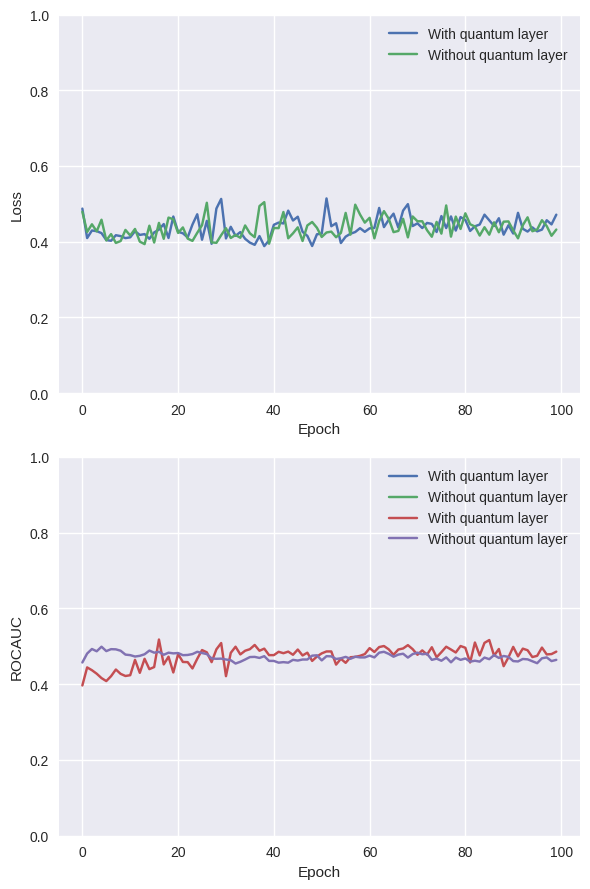

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 66.32%
Normal Model Accuracy: 71.88%
Hybrid Model F1 Score: 0.6417
Normal Model F1 Score: 0.6589
Hybrid Model AUC: 0.4735
Normal Model AUC: 0.4860


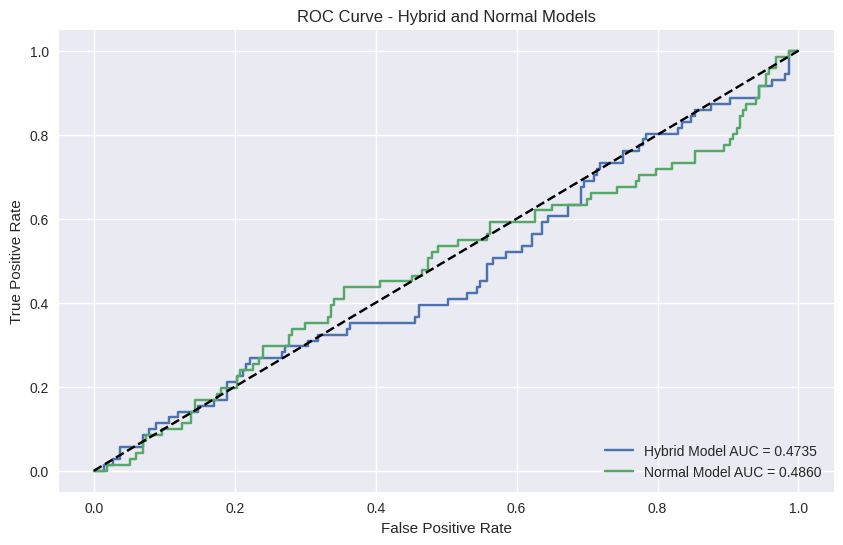

Hybrid Model AUPR: 0.2382
Normal Model AUPR: 0.2413


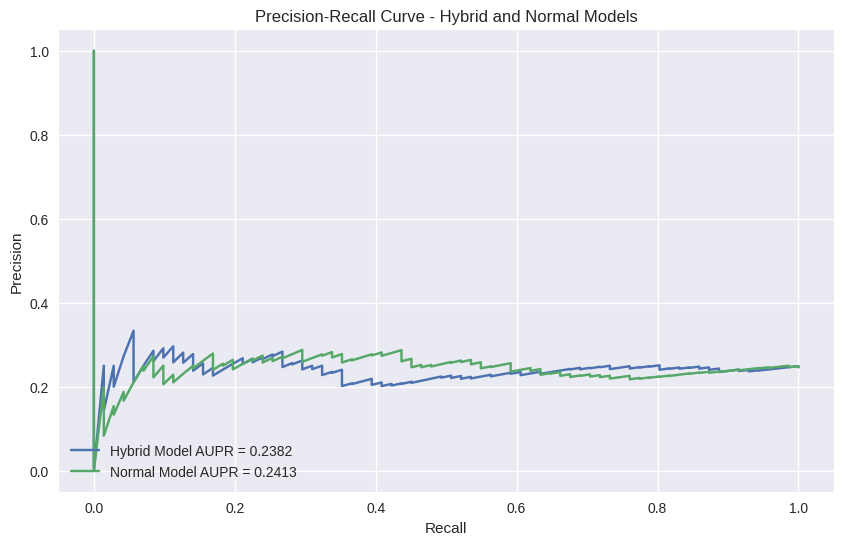

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 2

In [ ]:
seed = 42
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7195, Training Accuracy: 44.67%, Training AUROC: 0.5186
Validation Loss: 0.5870, Validation Accuracy: 55.47%, Validation AUROC: 0.5185
Epoch [2/100]
Training Loss: 0.6132, Training Accuracy: 67.83%, Training AUROC: 0.5010
Validation Loss: 0.4232, Validation Accuracy: 82.03%, Validation AUROC: 0.4880
Epoch [3/100]
Training Loss: 0.6078, Training Accuracy: 70.77%, Training AUROC: 0.4961
Validation Loss: 0.4232, Validation Accuracy: 82.03%, Validation AUROC: 0.4912
Epoch [4/100]
Training Loss: 0.5987, Training Accuracy: 70.04%, Training AUROC: 0.5146
Validation Loss: 0.4441, Validation Accuracy: 80.47%, Validation AUROC: 0.4884
Epoch [5/100]
Training Loss: 0.5917, Training Accuracy: 70.59%, Training AUROC: 0.5305
Validation Loss: 0.4302, Validation Accuracy: 82.81%, Validation AUROC: 0.4856
Epoch [6/100]
Training Loss: 0.6030, Training Accuracy: 70.77%, Training AUROC: 0.4799
Validation Loss: 0.4246, Validation Accuracy: 83.59%, Validation AUROC: 0.4796
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7288, Training Accuracy: 34.56%, Training AUROC: 0.4498
Validation Loss: 0.5691, Validation Accuracy: 54.69%, Validation AUROC: 0.5731
Epoch [2/100]
Training Loss: 0.6430, Training Accuracy: 63.60%, Training AUROC: 0.4715
Validation Loss: 0.4719, Validation Accuracy: 84.38%, Validation AUROC: 0.6528
Epoch [3/100]
Training Loss: 0.5996, Training Accuracy: 70.77%, Training AUROC: 0.4682
Validation Loss: 0.4393, Validation Accuracy: 84.38%, Validation AUROC: 0.6444
Epoch [4/100]
Training Loss: 0.5913, Training Accuracy: 70.77%, Training AUROC: 0.4662
Validation Loss: 0.4332, Validation Accuracy: 84.38%, Validation AUROC: 0.6292
Epoch [5/100]
Training Loss: 0.5901, Training Accuracy: 70.77%, Training AUROC: 0.4808
Validation Loss: 0.4302, Validation Accuracy: 84.38%, Validation AUROC: 0.6157
Epoch [6/100]
Training Loss: 0.5916, Training Accuracy: 70.40%, Training AUROC: 0.5025
Validation Loss: 0.4281, Validation Accuracy: 84.38%, Validation AUROC: 0.6102
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


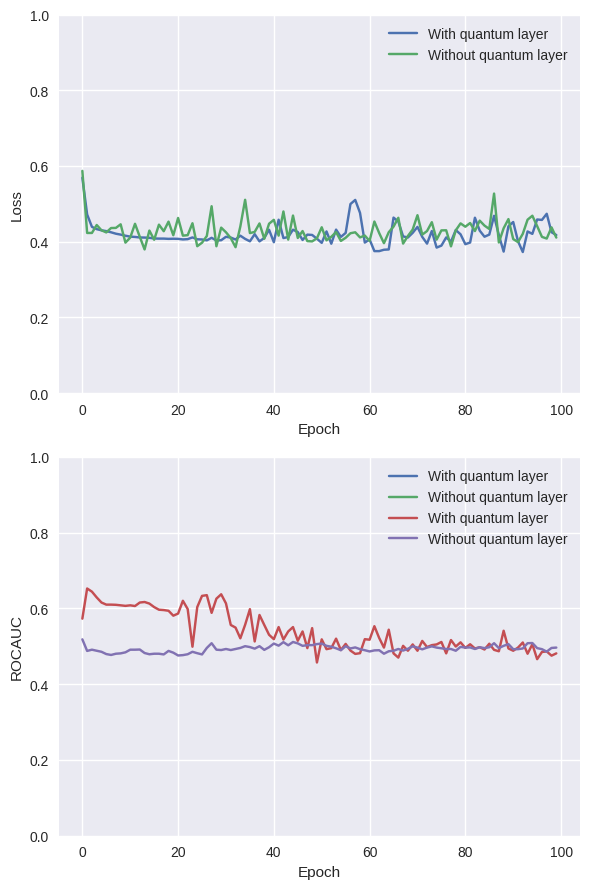

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 69.44%
Normal Model Accuracy: 72.57%
Hybrid Model F1 Score: 0.6399
Normal Model F1 Score: 0.6496
Hybrid Model AUC: 0.4856
Normal Model AUC: 0.4638


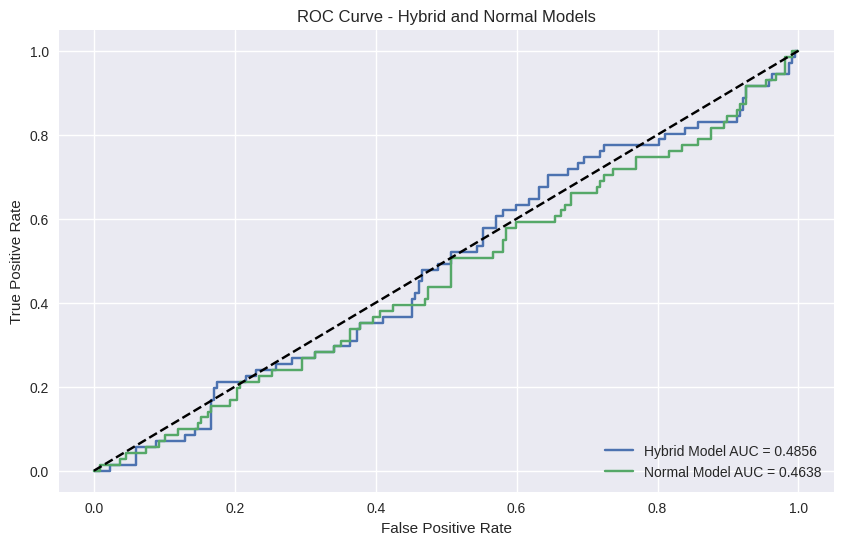

Hybrid Model AUPR: 0.2315
Normal Model AUPR: 0.2265


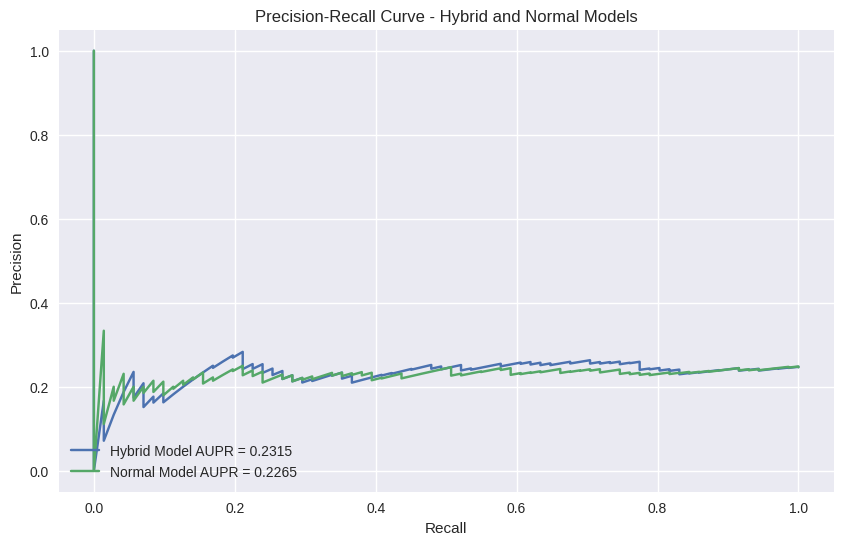

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 3

In [ ]:
seed = 5923
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6524, Training Accuracy: 61.21%, Training AUROC: 0.5325
Validation Loss: 0.4682, Validation Accuracy: 80.47%, Validation AUROC: 0.5407
Epoch [2/100]
Training Loss: 0.6110, Training Accuracy: 69.85%, Training AUROC: 0.4847
Validation Loss: 0.4108, Validation Accuracy: 84.38%, Validation AUROC: 0.4708
Epoch [3/100]
Training Loss: 0.6207, Training Accuracy: 69.12%, Training AUROC: 0.4677
Validation Loss: 0.4607, Validation Accuracy: 80.47%, Validation AUROC: 0.4625
Epoch [4/100]
Training Loss: 0.6084, Training Accuracy: 69.12%, Training AUROC: 0.4841
Validation Loss: 0.4228, Validation Accuracy: 82.81%, Validation AUROC: 0.4491
Epoch [5/100]
Training Loss: 0.6083, Training Accuracy: 69.85%, Training AUROC: 0.4866
Validation Loss: 0.4405, Validation Accuracy: 82.03%, Validation AUROC: 0.4537
Epoch [6/100]
Training Loss: 0.6025, Training Accuracy: 70.22%, Training AUROC: 0.5156
Validation Loss: 0.4303, Validation Accuracy: 83.59%, Validation AUROC: 0.4440
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6013, Training Accuracy: 70.77%, Training AUROC: 0.5302
Validation Loss: 0.4628, Validation Accuracy: 84.38%, Validation AUROC: 0.4181
Epoch [2/100]
Training Loss: 0.5901, Training Accuracy: 70.96%, Training AUROC: 0.5107
Validation Loss: 0.4318, Validation Accuracy: 84.38%, Validation AUROC: 0.4046
Epoch [3/100]
Training Loss: 0.5861, Training Accuracy: 70.77%, Training AUROC: 0.5064
Validation Loss: 0.4180, Validation Accuracy: 84.38%, Validation AUROC: 0.4194
Epoch [4/100]
Training Loss: 0.5802, Training Accuracy: 71.32%, Training AUROC: 0.5193
Validation Loss: 0.4133, Validation Accuracy: 84.38%, Validation AUROC: 0.4204
Epoch [5/100]
Training Loss: 0.5822, Training Accuracy: 70.96%, Training AUROC: 0.5353
Validation Loss: 0.4131, Validation Accuracy: 84.38%, Validation AUROC: 0.4116
Epoch [6/100]
Training Loss: 0.5789, Training Accuracy: 71.51%, Training AUROC: 0.4993
Validation Loss: 0.4121, Validation Accuracy: 84.38%, Validation AUROC: 0.4106
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


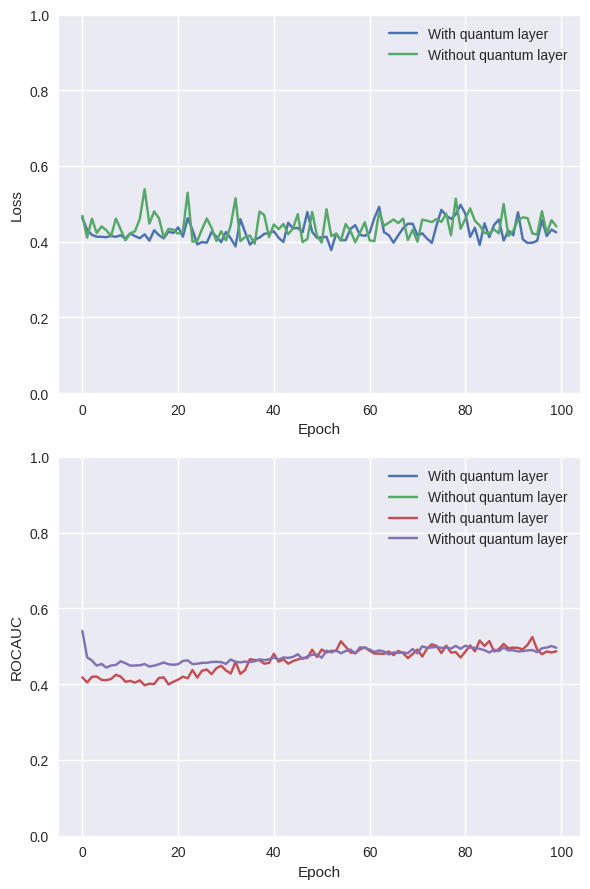

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 68.40%
Normal Model Accuracy: 69.44%
Hybrid Model F1 Score: 0.6372
Normal Model F1 Score: 0.6399
Hybrid Model AUC: 0.5219
Normal Model AUC: 0.4900


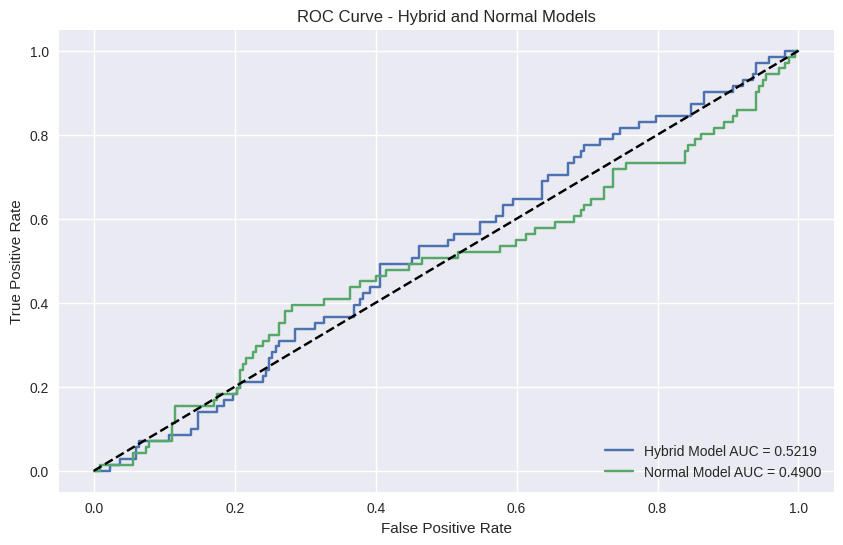

Hybrid Model AUPR: 0.2460
Normal Model AUPR: 0.2448


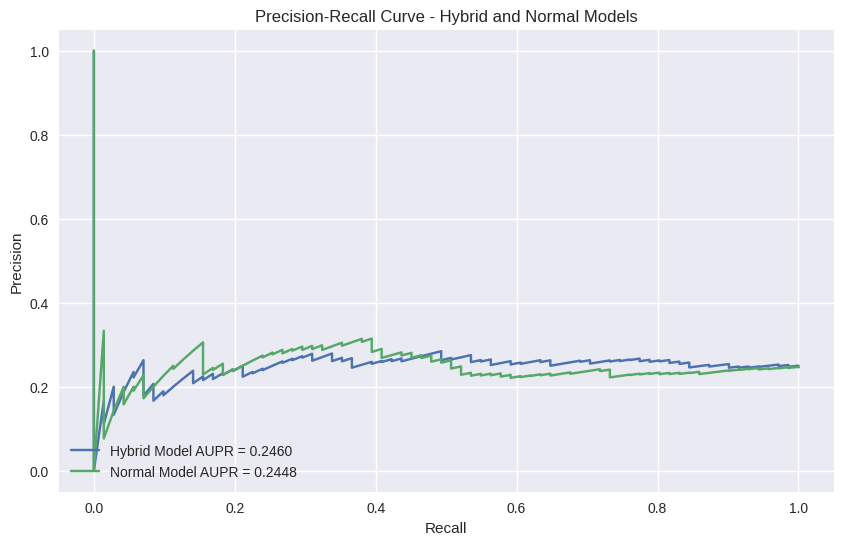

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 4

In [ ]:
seed = 8932
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6606, Training Accuracy: 55.88%, Training AUROC: 0.5063
Validation Loss: 0.4968, Validation Accuracy: 72.66%, Validation AUROC: 0.5106
Epoch [2/100]
Training Loss: 0.6116, Training Accuracy: 69.49%, Training AUROC: 0.4892
Validation Loss: 0.3917, Validation Accuracy: 83.59%, Validation AUROC: 0.5444
Epoch [3/100]
Training Loss: 0.6024, Training Accuracy: 71.51%, Training AUROC: 0.5126
Validation Loss: 0.3959, Validation Accuracy: 83.59%, Validation AUROC: 0.5551
Epoch [4/100]
Training Loss: 0.6155, Training Accuracy: 68.75%, Training AUROC: 0.4882
Validation Loss: 0.4065, Validation Accuracy: 82.81%, Validation AUROC: 0.5722
Epoch [5/100]
Training Loss: 0.6003, Training Accuracy: 70.04%, Training AUROC: 0.5203
Validation Loss: 0.4155, Validation Accuracy: 82.03%, Validation AUROC: 0.5579
Epoch [6/100]
Training Loss: 0.5952, Training Accuracy: 70.22%, Training AUROC: 0.5524
Validation Loss: 0.3859, Validation Accuracy: 83.59%, Validation AUROC: 0.5560
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.5875, Training Accuracy: 70.59%, Training AUROC: 0.5421
Validation Loss: 0.4041, Validation Accuracy: 84.38%, Validation AUROC: 0.3907
Epoch [2/100]
Training Loss: 0.5952, Training Accuracy: 70.77%, Training AUROC: 0.5082
Validation Loss: 0.4313, Validation Accuracy: 85.16%, Validation AUROC: 0.4106
Epoch [3/100]
Training Loss: 0.5804, Training Accuracy: 71.51%, Training AUROC: 0.5389
Validation Loss: 0.4085, Validation Accuracy: 84.38%, Validation AUROC: 0.4190
Epoch [4/100]
Training Loss: 0.5864, Training Accuracy: 70.40%, Training AUROC: 0.5616
Validation Loss: 0.4313, Validation Accuracy: 84.38%, Validation AUROC: 0.4356
Epoch [5/100]
Training Loss: 0.5893, Training Accuracy: 70.77%, Training AUROC: 0.5121
Validation Loss: 0.4121, Validation Accuracy: 84.38%, Validation AUROC: 0.4356
Epoch [6/100]
Training Loss: 0.5848, Training Accuracy: 70.96%, Training AUROC: 0.5356
Validation Loss: 0.4159, Validation Accuracy: 84.38%, Validation AUROC: 0.4319
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


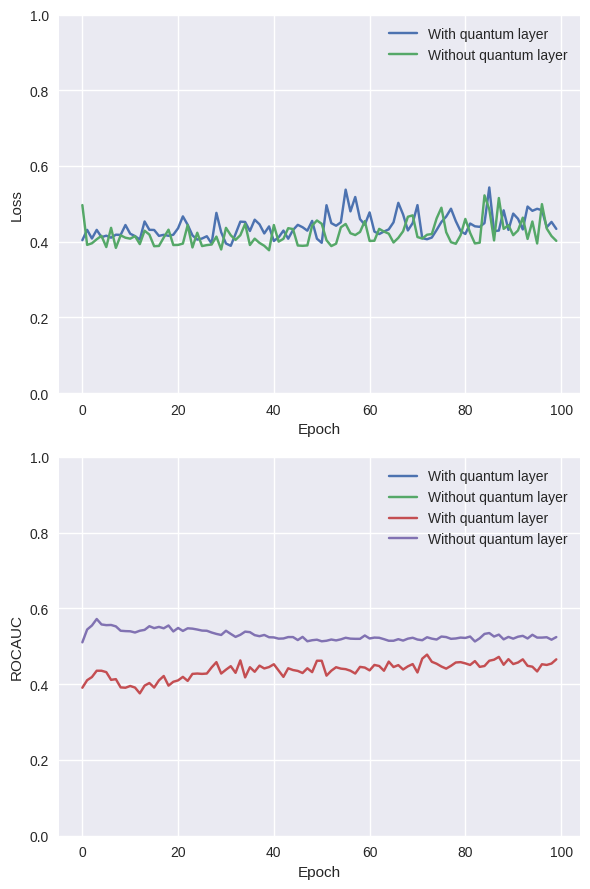

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 72.22%
Normal Model Accuracy: 71.53%
Hybrid Model F1 Score: 0.6375
Normal Model F1 Score: 0.6338
Hybrid Model AUC: 0.4739
Normal Model AUC: 0.4780


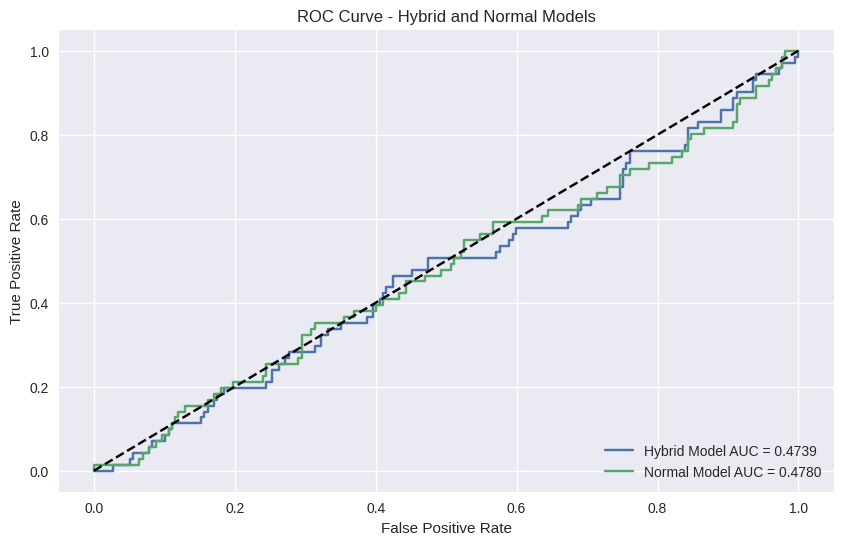

Hybrid Model AUPR: 0.2302
Normal Model AUPR: 0.2466


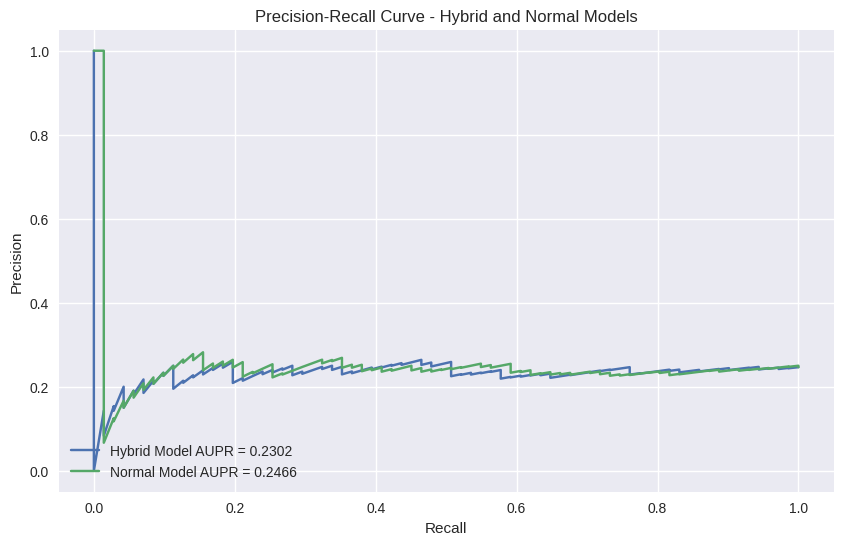

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

Seed Experiments 5

In [ ]:
seed = 56
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7845, Training Accuracy: 38.60%, Training AUROC: 0.4977
Validation Loss: 0.6833, Validation Accuracy: 32.81%, Validation AUROC: 0.4208
Epoch [2/100]
Training Loss: 0.6221, Training Accuracy: 64.52%, Training AUROC: 0.5245
Validation Loss: 0.4364, Validation Accuracy: 84.38%, Validation AUROC: 0.4505
Epoch [3/100]
Training Loss: 0.6035, Training Accuracy: 70.59%, Training AUROC: 0.5358
Validation Loss: 0.4104, Validation Accuracy: 84.38%, Validation AUROC: 0.4644
Epoch [4/100]
Training Loss: 0.5950, Training Accuracy: 70.96%, Training AUROC: 0.5479
Validation Loss: 0.4335, Validation Accuracy: 84.38%, Validation AUROC: 0.4745
Epoch [5/100]
Training Loss: 0.5995, Training Accuracy: 70.22%, Training AUROC: 0.5212
Validation Loss: 0.4255, Validation Accuracy: 84.38%, Validation AUROC: 0.4755
Epoch [6/100]
Training Loss: 0.5929, Training Accuracy: 70.59%, Training AUROC: 0.5513
Validation Loss: 0.4455, Validation Accuracy: 82.81%, Validation AUROC: 0.4755
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6729, Training Accuracy: 55.33%, Training AUROC: 0.4667
Validation Loss: 0.5120, Validation Accuracy: 74.22%, Validation AUROC: 0.4875
Epoch [2/100]
Training Loss: 0.6101, Training Accuracy: 70.04%, Training AUROC: 0.4890
Validation Loss: 0.4601, Validation Accuracy: 84.38%, Validation AUROC: 0.4481
Epoch [3/100]
Training Loss: 0.5913, Training Accuracy: 71.32%, Training AUROC: 0.4455
Validation Loss: 0.4389, Validation Accuracy: 84.38%, Validation AUROC: 0.4519
Epoch [4/100]
Training Loss: 0.5871, Training Accuracy: 71.14%, Training AUROC: 0.5293
Validation Loss: 0.4331, Validation Accuracy: 84.38%, Validation AUROC: 0.4602
Epoch [5/100]
Training Loss: 0.5849, Training Accuracy: 71.32%, Training AUROC: 0.5118
Validation Loss: 0.4280, Validation Accuracy: 84.38%, Validation AUROC: 0.4625
Epoch [6/100]
Training Loss: 0.5863, Training Accuracy: 70.96%, Training AUROC: 0.5107
Validation Loss: 0.4249, Validation Accuracy: 84.38%, Validation AUROC: 0.4694
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


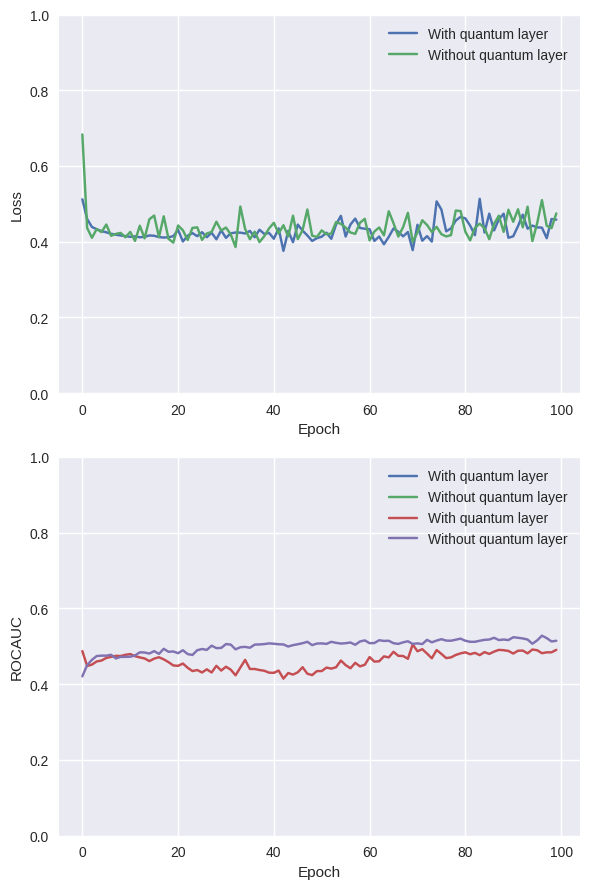

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 65.62%
Normal Model Accuracy: 67.71%
Hybrid Model F1 Score: 0.6344
Normal Model F1 Score: 0.6514
Hybrid Model AUC: 0.4786
Normal Model AUC: 0.4849


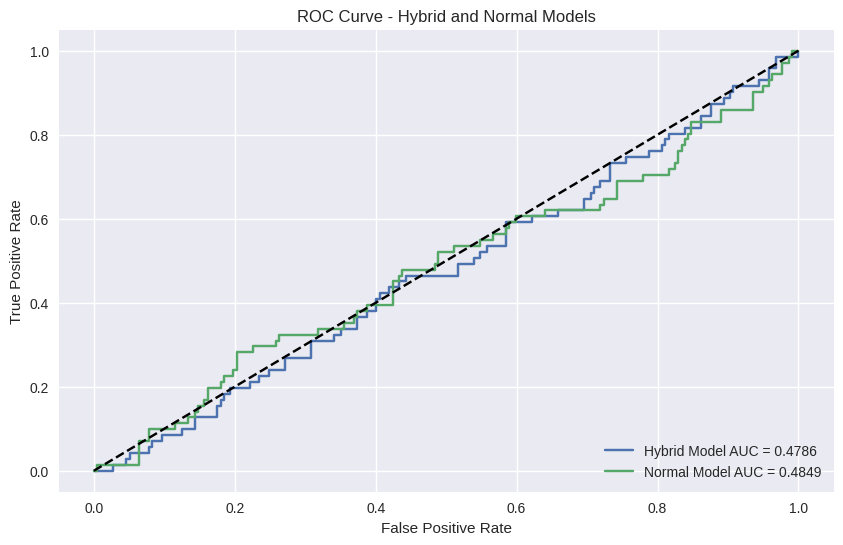

Hybrid Model AUPR: 0.2300
Normal Model AUPR: 0.2433


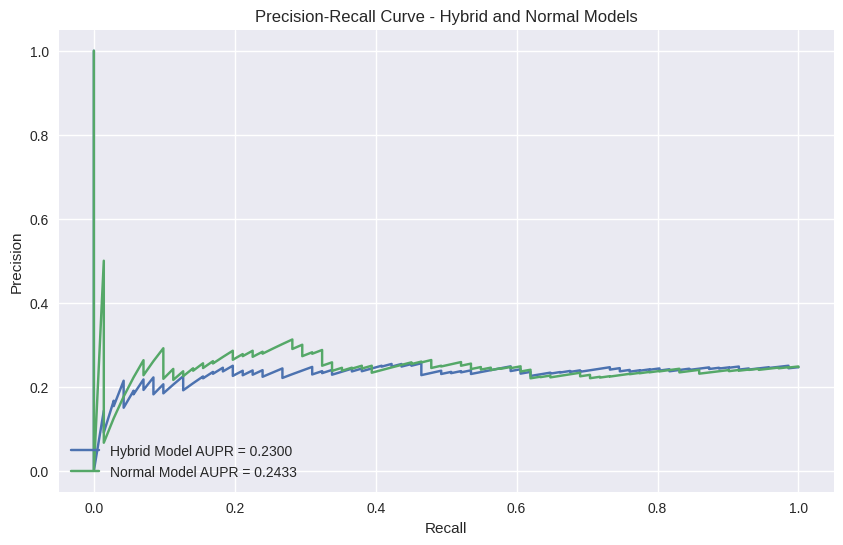

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Testing G1020-Trained Model on PAPILA

In [ ]:
batch_size = 32
dataset = "PAPILA"
num_classes= 2
q_depth = 4
PAPILA_dual_class=True

In [ ]:
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset, PAPILA_dual_class=PAPILA_dual_class)

### Testing Model From Seed 1

Hybrid Model Accuracy: 59.38%
Normal Model Accuracy: 66.67%
Hybrid Model F1 Score: 0.5200
Normal Model F1 Score: 0.5583
Hybrid Model AUC: 0.4344
Normal Model AUC: 0.4442


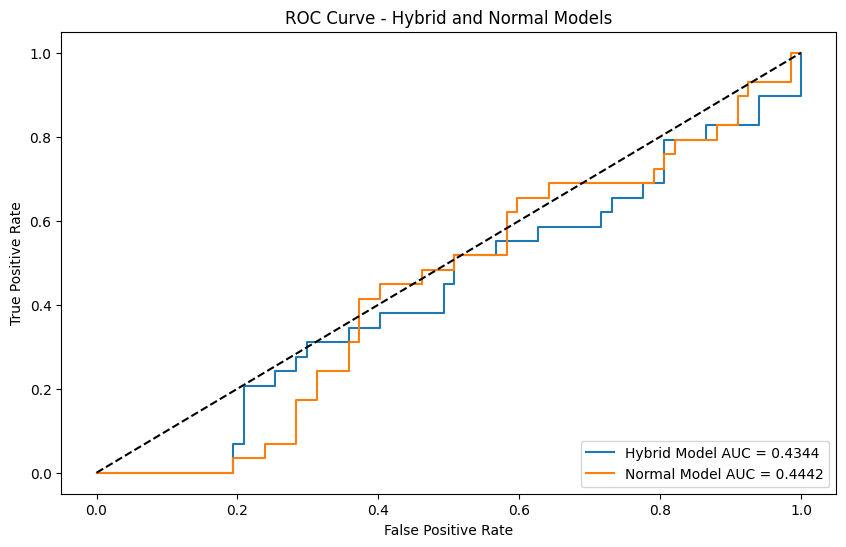

Hybrid Model AUPR: 0.2592
Normal Model AUPR: 0.2574


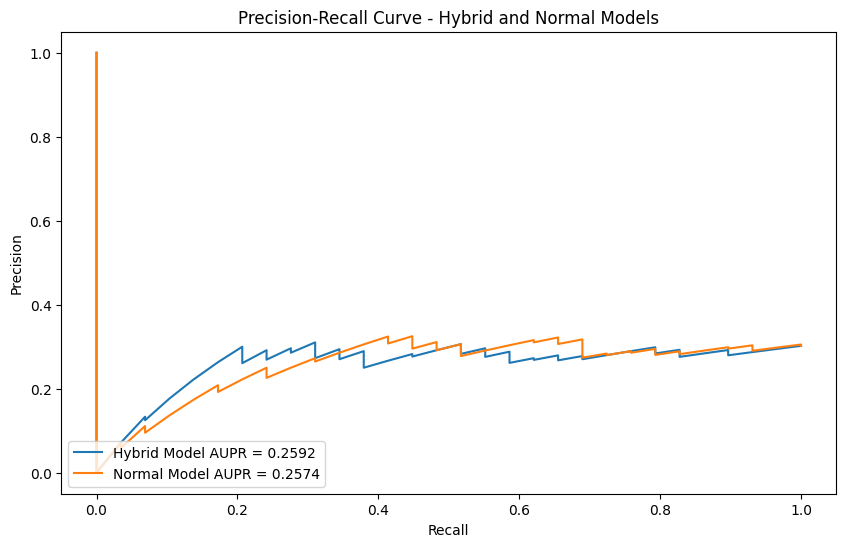

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/normal_model_0.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/quantum_hybrid_model_0.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 2

Hybrid Model Accuracy: 61.46%
Normal Model Accuracy: 66.67%
Hybrid Model F1 Score: 0.5313
Normal Model F1 Score: 0.5583
Hybrid Model AUC: 0.4493
Normal Model AUC: 0.4159


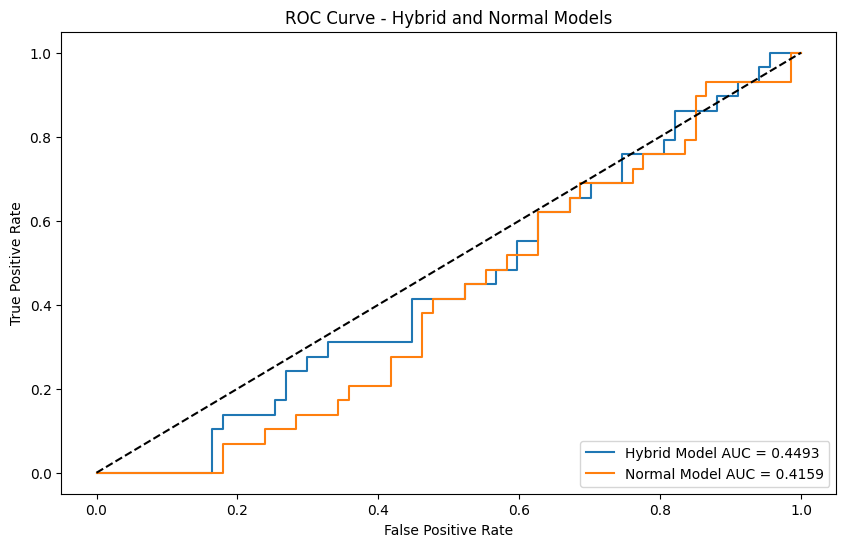

Hybrid Model AUPR: 0.2602
Normal Model AUPR: 0.2437


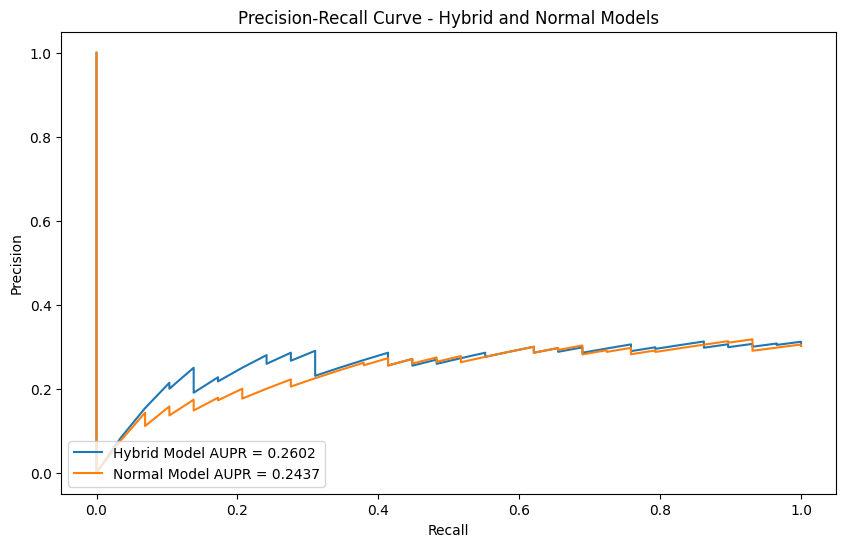

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/normal_model_42.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/quantum_hybrid_model_42.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 3

Hybrid Model Accuracy: 59.38%
Normal Model Accuracy: 64.58%
Hybrid Model F1 Score: 0.5324
Normal Model F1 Score: 0.5477
Hybrid Model AUC: 0.4112
Normal Model AUC: 0.3978


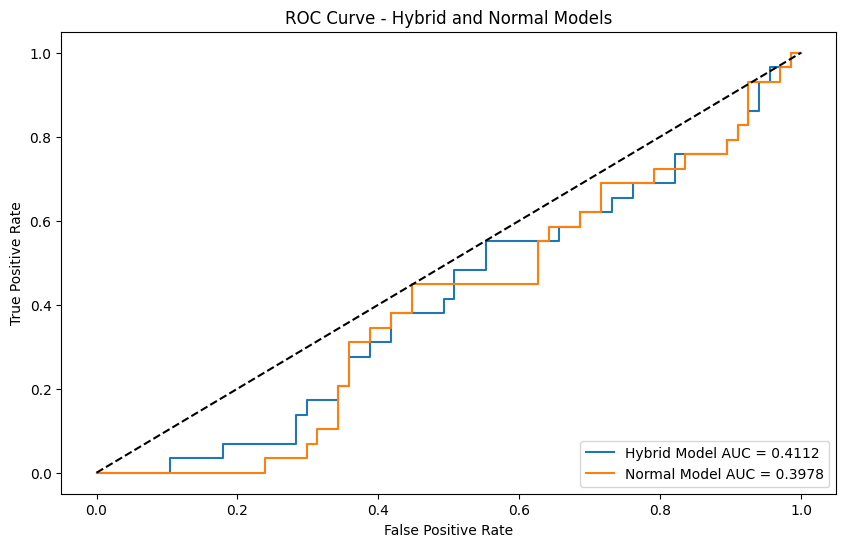

Hybrid Model AUPR: 0.2449
Normal Model AUPR: 0.2409


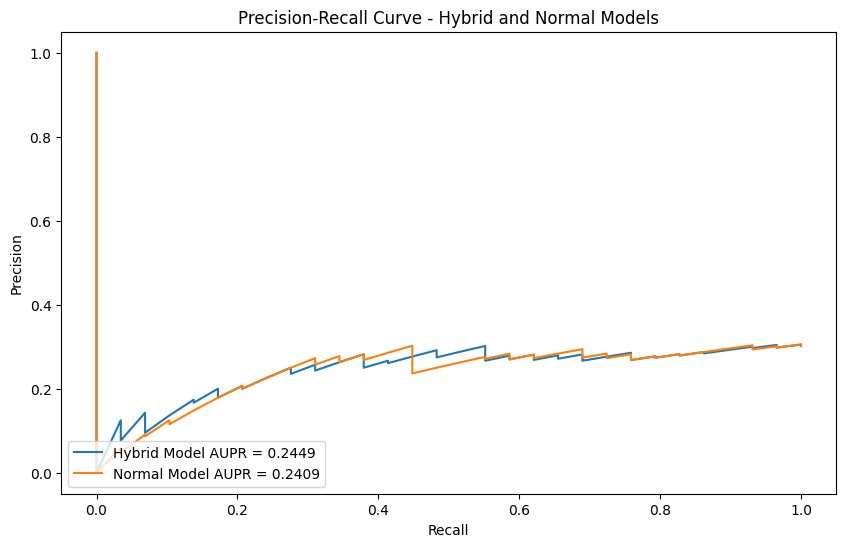

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 4

Hybrid Model Accuracy: 66.67%
Normal Model Accuracy: 66.67%
Hybrid Model F1 Score: 0.5583
Normal Model F1 Score: 0.5583
Hybrid Model AUC: 0.3747
Normal Model AUC: 0.3721


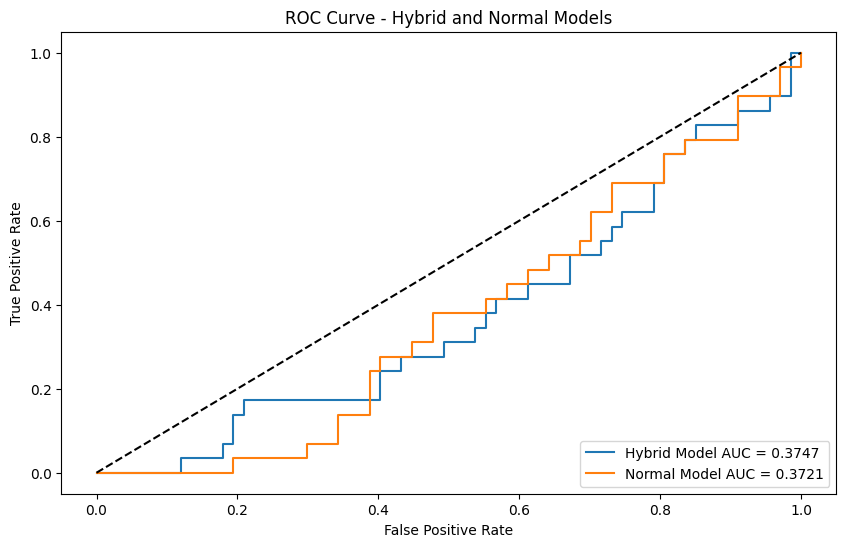

Hybrid Model AUPR: 0.2344
Normal Model AUPR: 0.2304


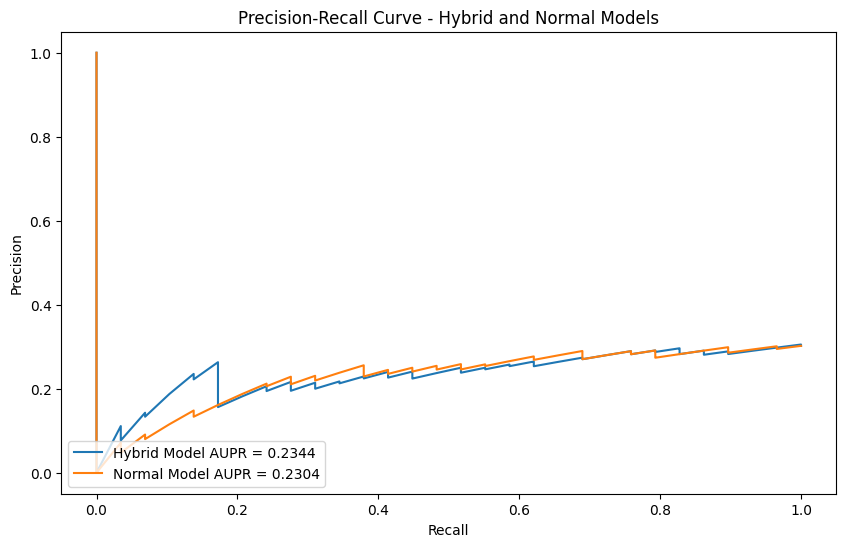

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/normal_model_8932.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/quantum_hybrid_model_8932.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

## Testing Model From Seed 5

Hybrid Model Accuracy: 63.54%
Normal Model Accuracy: 62.50%
Hybrid Model F1 Score: 0.5423
Normal Model F1 Score: 0.5369
Hybrid Model AUC: 0.4452
Normal Model AUC: 0.3798


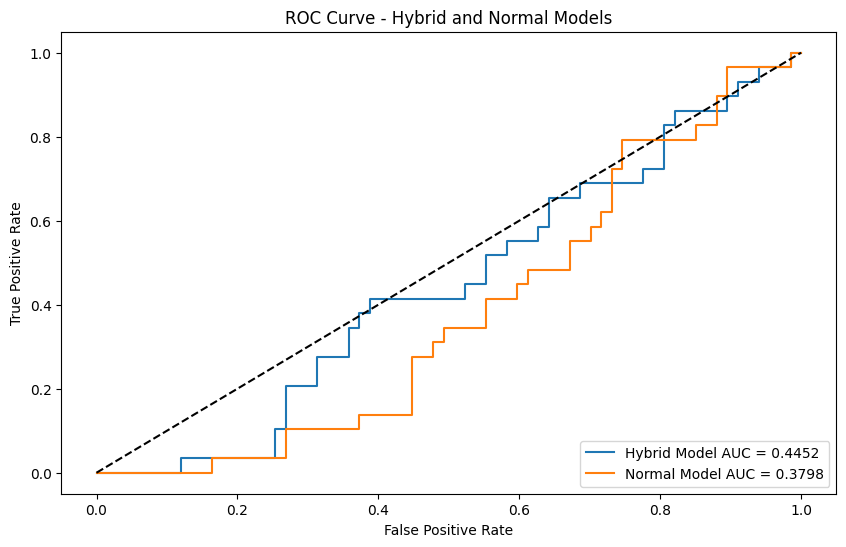

Hybrid Model AUPR: 0.2569
Normal Model AUPR: 0.2311


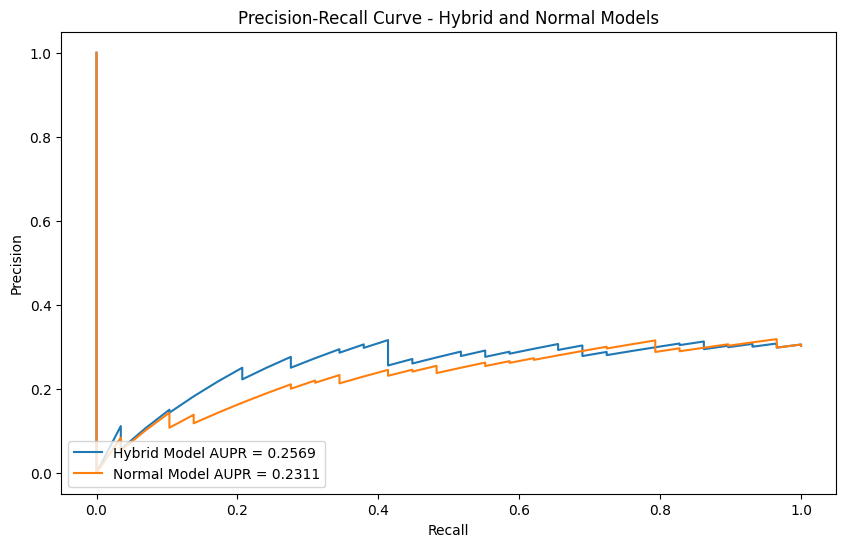

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/normal_model_5923.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020_models/quantum_hybrid_model_5923.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)